# Flex Net: A Configurable Neural Network for Sound Parsing

### Avant Garde Composer

Code to generate batches of random marimba compositions (with piano roll and corresponding audio)

In [1]:
import tensorflow as tf
from sonic2 import *

class Generate_Batch():
    def __init__(self, batch_size, length_in_beats, sample_rate, bpm):
        self.song = Song(SampleBank(restricted_instruments=['Marimba_cord_ff']),
                         length_in_beats, bpm, sample_rate)
        self.batch_size = batch_size
        self.num_inst_samples = self.song.num_inst_samples
        self.length_in_beats = length_in_beats
        self.bpm = bpm
        self.sr = sample_rate
        self.N = self.sr * self.length_in_beats * 60 // self.bpm
        self.samples_per_beat = (self.sr * 60) // self.bpm
        self.batch_audio = tf.Variable(tf.zeros([self.batch_size, self.length_in_beats-4, self.samples_per_beat*5], dtype=tf.float32))
        self.batch_piano_roll = tf.Variable(tf.zeros([self.batch_size, self.length_in_beats-4, self.num_inst_samples], dtype=tf.float32))
    
    #@tf.function
    def __chop__(self, song_output, song_notes_float):
        audio = tf.TensorArray(tf.float32, size=(self.length_in_beats-4), element_shape=(self.samples_per_beat*5,))
        piano_roll = tf.TensorArray(tf.float32, size=(self.length_in_beats-4), element_shape=(self.num_inst_samples,))
        for j in tf.range(2, self.song.length_in_beats - 2):
            audio = audio.write(j-2, song_output[(j-2)*self.samples_per_beat:(j+3)*self.samples_per_beat])
            piano_roll = piano_roll.write(j-2, tf.reshape(song_notes_float, [self.song.length_in_beats, self.song.num_inst_samples])[j])
        return audio.stack(), piano_roll.stack()
    
    @tf.function
    def __call2__(self):
        for i in range(self.batch_size):
            output, notes_float = self.song.create()
            audio, piano_roll = self.__chop__(output, notes_float)
            self.batch_audio[i].assign(audio)
            self.batch_piano_roll[i].assign(piano_roll)
        return self.batch_audio, self.batch_piano_roll

    #@tf.function
    def __call__(self):
        for i in range(self.batch_size):
            self.song.zero()
            for j in range(np.random.choice([3,4,5,6,7,8,9,10,11,12])):
                self.song.generate()
            audio, piano_roll = self.__chop__(self.song.output, self.song.notes_float)
            self.batch_audio[i].assign(audio)
            self.batch_piano_roll[i].assign(piano_roll)
        return self.batch_audio, self.batch_piano_roll    

In [2]:
batch_size = 10
batches_per_epoch = 1

generate_batch = Generate_Batch(batch_size, 4*10, 44100, 60*10)

Marimba_cord_ff  --- notes  36  through  96


In [3]:
a, p = generate_batch()

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))

ax.imshow(p[0].numpy(), aspect=(1), cmap='inferno')

In [5]:
# Example of a random composition

from IPython.display import Audio

generate_batch.song.generate()
example_composition = generate_batch.song.output.numpy()

Audio(example_composition, rate=44100, autoplay=True)

## Neural Network Classes

In [7]:
from neural2 import *

class Network(tf.Module):
    def __init__(self, name=None):
        super(Network, self).__init__(name=name)
        self.layers = []
        
                
        sample_rate = 44100                 # 44.1khz sample rate
        frame_length = sample_rate // 10    # frame size of 0.1 seconds
        num_frames = 5                      # five frames read at a time
        input_features = int(frame_length * num_frames)
    
        self.layers.append(DisperseLayer(input_features, frame_length, 1.0))
        num_chunks = num_frames
        
        self.layers.append(RFFTLayer(self.layers[-1].chunk_size))
        
        self.layers.append(ReluNormLayer(self.layers[-1].output_features, self.layers[-1].output_features))
        self.layers.append(ReluNormLayer(self.layers[-1].output_features, self.layers[-1].output_features // 64))
    
        
        self.layers.append(JoinLayer(self.layers[-1].output_features, num_chunks))
        
        self.layers.append(ReluNormLayer(self.layers[-1].output_features, self.layers[-1].output_features // 4))
        self.layers.append(SigmoidNormLayer(self.layers[-1].output_features, 61))
        

    def save(self, path):
        if not os.path.exists(path):
            os.makedirs(path)
        for i, layer in enumerate(self.layers):
            if not os.path.exists(os.path.join(path, f'layer_{i}')):
                os.makedirs(os.path.join(path, f'layer_{i}'))
            layer.save(os.path.join(path, f'layer_{i}'))
            
    def load(self, path):
        for i, layer in enumerate(self.layers):
            layer.load(os.path.join(path, f'layer_{i}'))
        
    def apply(self, data, layers):
        if len(layers) == 1:
            return layers[0](data)
        else:
            return self.apply(layers[0](data), layers[1:])

    #@tf.function
    def __call__(self, data):
        x = data
        for i, layer in enumerate(self.layers):
            x = layer(x)
        return x
        #return self.apply(data, self.layers)
        
    def reset(self):
        for layer in self.layers:
            layer.reset()

network = Network()

Disperse Layer. Input Features: 22050 Chunk Size: 4410 Num Chunks: 5
RFFT Layer. Input Features: 4410 Output Features: 8194
RELU Layer. Input Features: 8194 Output Features: 8194
RELU Layer. Input Features: 8194 Output Features: 128
Join Layer. Input Chunk Size: 128 Num Input Chunks: 5 Output Features: 640
RELU Layer. Input Features: 640 Output Features: 160
RELU Layer. Input Features: 160 Output Features: 61


In [8]:
def clean_output(arr):
    N = arr.shape[0]
    M = arr.shape[1]
    output = np.zeros([N, M])
    for i in range(N):
        for j in range(M):
            output[i][j] = int(max(0, min(127, round(128 * arr[i][j]))))
    return output

In [16]:
network.reset()

Epoch 6699 completed!
Step 6699 complete.
Cost: 0.212171316 Note Cost: 0.212171316
Global Norm: 0.0020436863


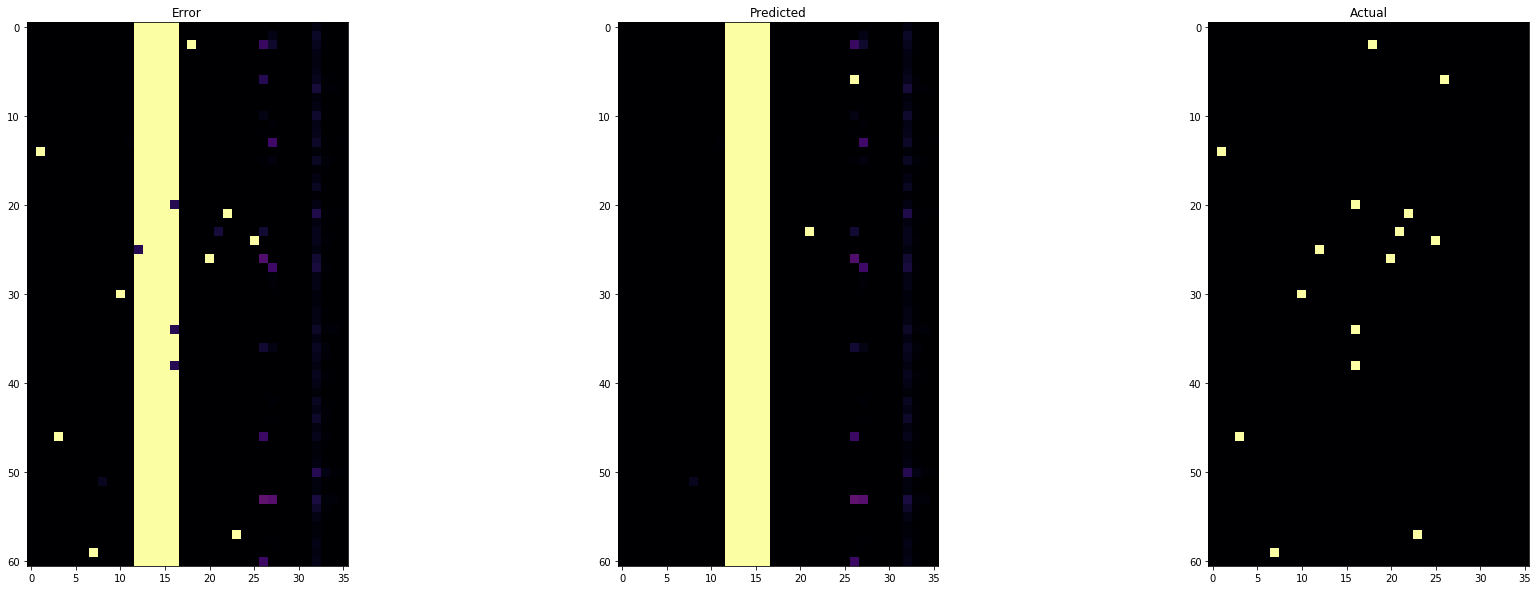

Epoch 6700 completed!
Step 6700 complete.
Cost: 0.212169483 Note Cost: 0.212169483
Global Norm: 0.0020207237
Epoch 6701 completed!
Step 6701 complete.
Cost: 0.212167785 Note Cost: 0.212167785
Global Norm: 0.0020171767
Epoch 6702 completed!
Step 6702 complete.
Cost: 0.212165982 Note Cost: 0.212165982
Global Norm: 0.0020204312
Epoch 6703 completed!
Step 6703 complete.
Cost: 0.212164298 Note Cost: 0.212164298
Global Norm: 0.0020280154
Epoch 6704 completed!
Step 6704 complete.
Cost: 0.21216251 Note Cost: 0.21216251
Global Norm: 0.0020908362
Epoch 6705 completed!
Step 6705 complete.
Cost: 0.2121609 Note Cost: 0.2121609
Global Norm: 0.0020483944
Epoch 6706 completed!
Step 6706 complete.
Cost: 0.212159052 Note Cost: 0.212159052
Global Norm: 0.0020022052
Epoch 6707 completed!
Step 6707 complete.
Cost: 0.212157354 Note Cost: 0.212157354
Global Norm: 0.001994943
Epoch 6708 completed!
Step 6708 complete.
Cost: 0.212155595 Note Cost: 0.212155595
Global Norm: 0.0019796009
Epoch 6709 completed!
Step

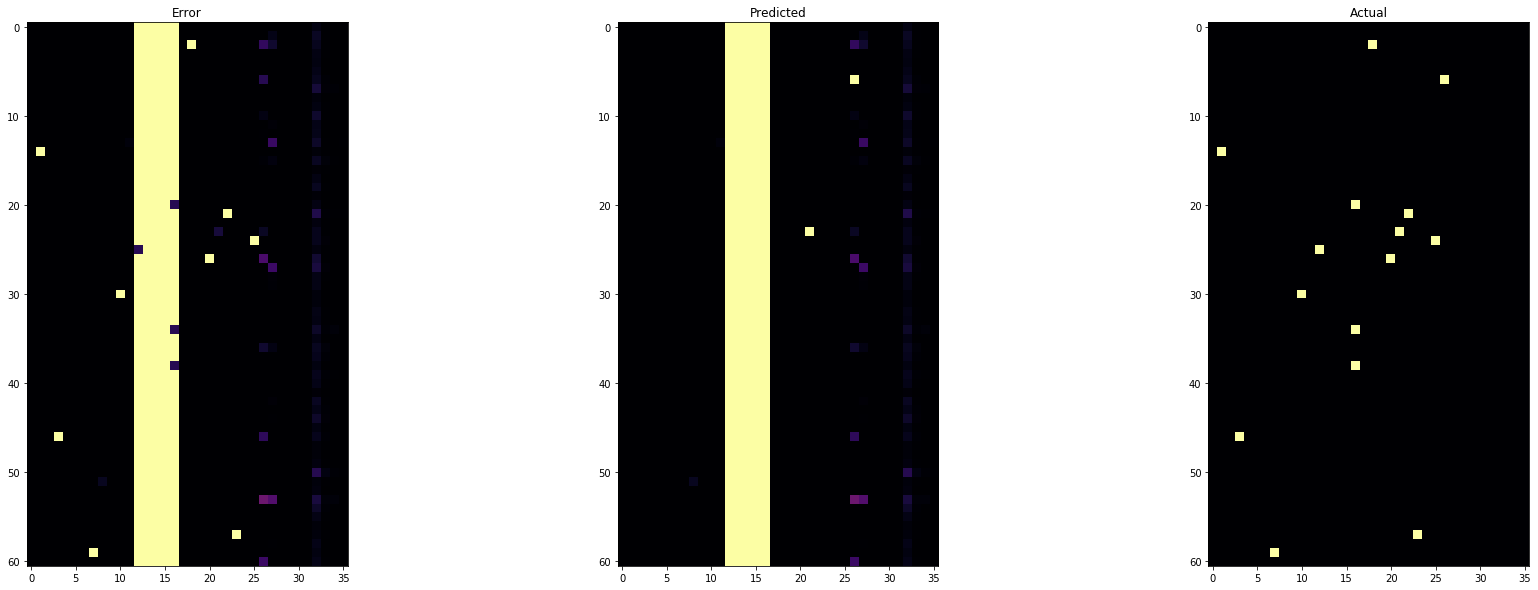

Epoch 6710 completed!
Step 6710 complete.
Cost: 0.212152198 Note Cost: 0.212152198
Global Norm: 0.0019760053
Epoch 6711 completed!
Step 6711 complete.
Cost: 0.212150559 Note Cost: 0.212150559
Global Norm: 0.0019748865
Epoch 6712 completed!
Step 6712 complete.
Cost: 0.212148905 Note Cost: 0.212148905
Global Norm: 0.0020114458
Epoch 6713 completed!
Step 6713 complete.
Cost: 0.21214731 Note Cost: 0.21214731
Global Norm: 0.001975502
Epoch 6714 completed!
Step 6714 complete.
Cost: 0.212145656 Note Cost: 0.212145656
Global Norm: 0.0019811965
Epoch 6715 completed!
Step 6715 complete.
Cost: 0.212144196 Note Cost: 0.212144196
Global Norm: 0.002822638
Epoch 6716 completed!
Step 6716 complete.
Cost: 0.212142989 Note Cost: 0.212142989
Global Norm: 0.0021902889
Epoch 6717 completed!
Step 6717 complete.
Cost: 0.212141484 Note Cost: 0.212141484
Global Norm: 0.0020619384
Epoch 6718 completed!
Step 6718 complete.
Cost: 0.212139666 Note Cost: 0.212139666
Global Norm: 0.0020927892
Epoch 6719 completed!
S

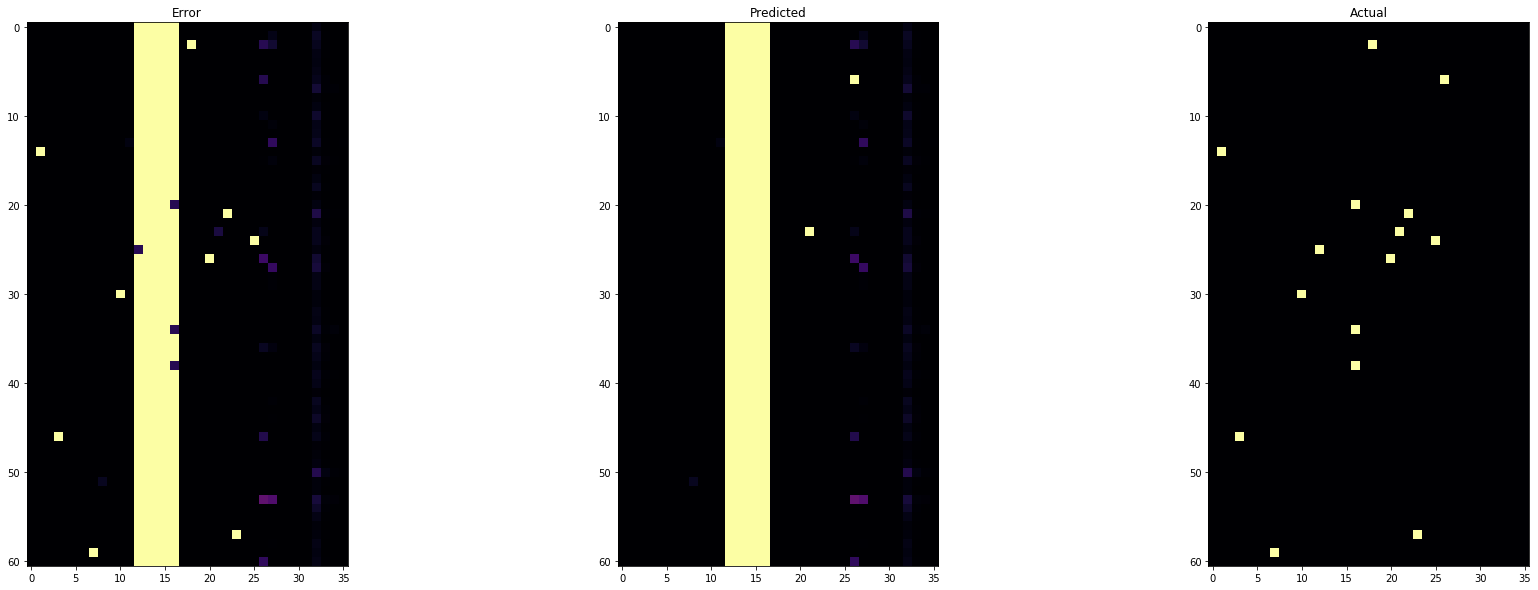

Epoch 6720 completed!
Step 6720 complete.
Cost: 0.212136552 Note Cost: 0.212136552
Global Norm: 0.004461386
Epoch 6721 completed!
Step 6721 complete.
Cost: 0.212136149 Note Cost: 0.212136149
Global Norm: 0.0021318863
Epoch 6722 completed!
Step 6722 complete.
Cost: 0.212134212 Note Cost: 0.212134212
Global Norm: 0.002050043
Epoch 6723 completed!
Step 6723 complete.
Cost: 0.212132588 Note Cost: 0.212132588
Global Norm: 0.002046165
Epoch 6724 completed!
Step 6724 complete.
Cost: 0.212130785 Note Cost: 0.212130785
Global Norm: 0.0020517881
Epoch 6725 completed!
Step 6725 complete.
Cost: 0.212129205 Note Cost: 0.212129205
Global Norm: 0.002040833
Epoch 6726 completed!
Step 6726 complete.
Cost: 0.212127522 Note Cost: 0.212127522
Global Norm: 0.0028926416
Epoch 6727 completed!
Step 6727 complete.
Cost: 0.212126315 Note Cost: 0.212126315
Global Norm: 0.002089285
Epoch 6728 completed!
Step 6728 complete.
Cost: 0.212124556 Note Cost: 0.212124556
Global Norm: 0.0024658847
Epoch 6729 completed!
St

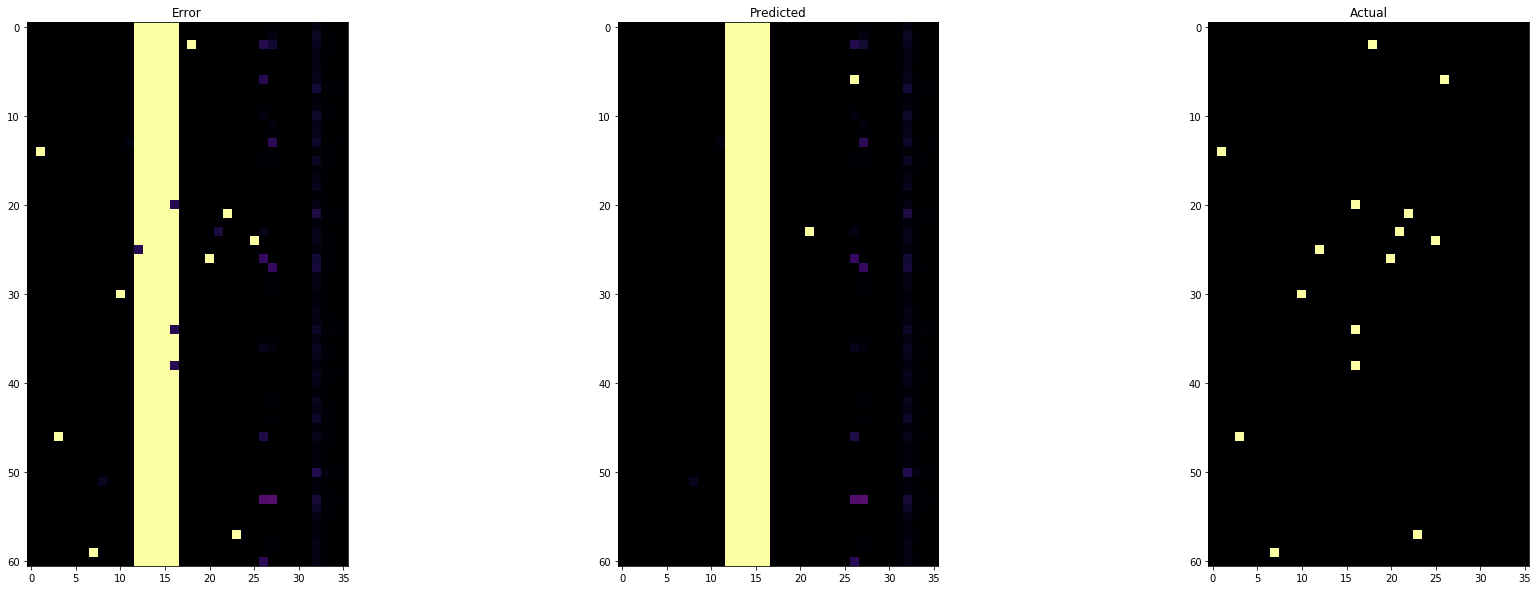

Epoch 6730 completed!
Step 6730 complete.
Cost: 0.21212174 Note Cost: 0.21212174
Global Norm: 0.0020705946
Epoch 6731 completed!
Step 6731 complete.
Cost: 0.21212022 Note Cost: 0.21212022
Global Norm: 0.0020370733
Epoch 6732 completed!
Step 6732 complete.
Cost: 0.21211876 Note Cost: 0.21211876
Global Norm: 0.004445865
Epoch 6733 completed!
Step 6733 complete.


In [17]:
from IPython.display import display, clear_output, Audio
import seaborn as sns
import sys, signal
import matplotlib.pyplot as plt
import plotting

keep_going = True
def signal_handler(signal, frame):
    global keep_going
    keep_going = False
signal.signal(signal.SIGINT, signal_handler)

#@tf.function
def loss(trainable_variables, notes_actual, notes_predicted):
    note_cost1 = tf.reduce_mean((notes_actual - notes_predicted)**2)
    #note_cost2 = tf.reduce_mean(-notes_actual * tf.math.log(10**(-6) + notes_predicted) - (1 - notes_actual) * tf.math.log((1 + 10**(-6)) -  notes_predicted))
    #regularization_cost = 0.0
    #for i in range(len(trainable_variables)):
    #    regularization_cost +=  (1/100) * tf.reduce_sum(tf.math.maximum(trainable_variables[i], 0.0))
    cost = note_cost1
    tf.print('Cost:', cost, 'Note Cost:', note_cost1) #, 'Regularization Cost:', regularization_cost)
    return cost
    

@tf.function
def grad(network, input_pcms, notes_actual):
    with tf.GradientTape() as tape:
        tape.watch(network.trainable_variables)
        notes_predicted = network(input_pcms)
        loss_value = loss(network.trainable_variables, notes_actual, notes_predicted)
    return loss_value, notes_predicted, tf.clip_by_global_norm(tape.gradient(loss_value, network.trainable_variables), 1000000.0)

#@tf.function
def apply_grads(trainable_vars, grads, learning_rate):
    for i in range(len(grads)):
        trainable_vars[i].assign_sub(learning_rate * grads[i])

#optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9) #, momentum=0.01) #, momentum=0.1, nesterov=True)
#optimizer=tf.keras.optimizers.SGD(learning_rate=0.001)


num_inst_samples = 61
length_in_seconds = 4
quantization = 10
length_in_beats = length_in_seconds * quantization


learning_rate = 0.5
beta = 0.9
                                                          
grads = tuple(tf.Variable(tf.zeros_like(var, dtype=tf.float32)) for var in network.trainable_variables)
v = tuple(tf.Variable(tf.zeros_like(var, dtype=tf.float32)) for var in network.trainable_variables) 

i = -1
while keep_going:
    i += 1
    if i % 1000 == 0:                           
        input_pcms, notes_actual = generate_batch()

    loss_value, notes_predicted, (new_grads, global_norm) = grad(network, input_pcms, notes_actual)
    print('Global Norm:', global_norm.numpy())
    for j in range(len(grads)):
        grads[j].assign_add(tf.where(tf.math.is_nan(new_grads[j]), tf.zeros_like(new_grads[j]), new_grads[j]) / batches_per_epoch)

    if i % 100 == 99:
        clear_output()
        
    if i % 10 == 0:
        pass
        fig = plotting.error(notes_predicted, notes_actual)
        display(fig)
        plt.close(fig)
        del fig

    
    if (i % batches_per_epoch) == (batches_per_epoch - 1):
        for j in range(len(grads)):
            v[j].assign(beta * v[j] + (1.0 - beta) * grads[j])
        apply_grads(network.trainable_variables, grads, learning_rate)
        #optimizer.apply_gradients(zip(grads, network.trainable_variables))
    
        for j in range(len(grads)):
            grads[j].assign(tf.zeros_like(network.trainable_variables[j], dtype=tf.float32))

        print(f'Epoch {i // batches_per_epoch} completed!')
        
    if i % 1000 == 999:
        network.save('checkpoint4')
        print('Network Parameters Saved!')

    print('Step', i, 'complete.')


### Saving and Loading

In [ ]:
network.save('checkpoint4')

In [ ]:
network.load('checkpoint3')

### To run a single test example

In [ ]:
import plotting

input_pcms, notes_actual = generate_batch()

loss_value, notes_predicted, (new_grads, global_norm) = grad(network, input_pcms, notes_actual)
        
plt = plotting.error(notes_predicted, notes_actual)

del plt

In [ ]:
import gc

gc.collect()